In [1]:
from brix import Indicator, Handler
import Simulation, US_State
import geopandas as gpd
from shapely.geometry import Point, shape
import json
import requests
import urllib
from geogrid_tools import *

In [2]:
table_name='epa'
geom_type='block_group'

model_radius=15000
reference_radius=2500

- Create the handler
- Get the geogrid
- Identify the state
- Get the state geometry
- find the overlap
- Assign the sim, model, reference zones
- Append the grid "zones" to the actual zones (if the zones properties are updated in one indicator, will they be updated for all?)

- all the above in a world object?

In [3]:
h=Handler(table_name)

https://cityio.media.mit.edu/api/tables/list/ Attempt: 0
https://cityio.media.mit.edu/api/table/epa/meta/hashes/ Attempt: 0


In [4]:
# geogrid_data=h.get_geogrid_data(include_geometries=True)

In [5]:

# geogrid=geogrid_data.GEOGRID

In [6]:
# geogrid=h.get_GEOGRID()
# geom = [f['geometry'] for f in geogrid['features']]
# geogrid_gdp=gpd.GeoDataFrame({'geometry':geom})

In [7]:
get_url='https://cityio.media.mit.edu/api/table/'+table_name
with urllib.request.urlopen(get_url+'/GEOGRID') as url:
    geogrid=gpd.read_file(url.read().decode())

centroids=geogrid['geometry'].centroid
geogrid['x_centroid']=[c.x for c in centroids]
geogrid['y_centroid']=[c.y for c in centroids]
geogrid

/var/folders/30/clhynt5s7fx_3nyyxfl04f780000gn/T/ipykernel_26528/1794812704.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=geogrid['geometry'].centroid


,id,interactive,name,geometry,x_centroid,y_centroid
0,0,false,None,"POLYGON ((-122.13699 37.47812, -122.13673 37.4...",-122.136608,37.478019
1,1,false,None,"POLYGON ((-122.13648 37.47832, -122.13623 37.4...",-122.136106,37.478223
2,2,false,None,"POLYGON ((-122.13598 37.47852, -122.13573 37.4...",-122.135603,37.478426
3,3,Web,None,"POLYGON ((-122.13548 37.47873, -122.13522 37.4...",-122.135101,37.478629
4,4,Web,None,"POLYGON ((-122.13498 37.47893, -122.13472 37.4...",-122.134598,37.478832
...,...,...,...,...,...,...
160,160,false,None,"POLYGON ((-122.13040 37.47373, -122.13015 37.4...",-122.130025,37.473632
161,161,false,None,"POLYGON ((-122.12990 37.47393, -122.12965 37.4...",-122.129522,37.473835
162,162,false,None,"POLYGON ((-122.12940 37.47414, -122.12914 37.4...",-122.129020,37.474038
163,163,false,None,"POLYGON ((-122.12890 37.47434, -122.12864 37.4...",-122.128518,37.474241


In [8]:
types=json.load(open('./data/default_types.json'))

In [9]:
try:
    interactive_zone=gpd.read_file('./tables/{}/interactive.geojson'.format(table_name))
    print('using interactive zone')
except:
    interactive_zone=None
properties=init_geogrid(table_name, interactive_zone=interactive_zone, types=types)

using interactive zone
Initialise GEOGRID: <Response [200]>


In [10]:
state_fips=identify_state(properties)

Getting geometry (block_group) for state: California


/Users/ronandoorley/Documents/Media_Lab/CityScope/CS_Spatial_Modules/US_State.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geom['geometry'].centroid


Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting WAC data
Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting RAC data
Getting OD data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting OD data


<AxesSubplot:>

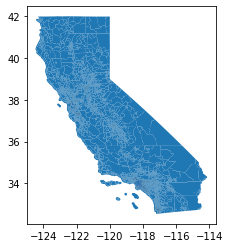

In [11]:
st=US_State.US_State(state_fips, year=2018, geom_type=geom_type)
st.get_geometry()
# st.remove_non_urban_zones()
st.get_lodes_data( include=['wac', 'rac', 'od'])
st.add_lodes_cols_to_shape()
st.geom.plot()

In [12]:
st.subset_geom_by_distance(centre_x_y=[geogrid.x_centroid.mean(), geogrid.y_centroid.mean()], 
                                   radius=reference_radius, name='reference_area')

st.subset_geom_by_distance(centre_x_y=[geogrid.x_centroid.mean(), geogrid.y_centroid.mean()], 
                                   radius=model_radius, name='model_area')

st.geom=assign_sim_area(gpd.GeoDataFrame(geogrid), st.geom)

	 Subsetting zones by distance
	 Subsetting zones by distance


/Users/ronandoorley/Documents/Media_Lab/CityScope/CS_Spatial_Modules/geogrid_tools.py:63: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  grid_intersect_zones=gpd.overlay(geogrid, zones, 'intersection')


In [13]:
zones=st.geom.rename(columns={col: 'area' for col in st.geom.columns if 'ALAND' in col})

In [14]:
import os
if not os.path.isdir('tables/{}'.format(table_name)):
    os.mkdir('tables/{}'.format(table_name))

In [15]:
zones.loc[zones['model_area']].to_file('tables/{}/zones.geojson'.format(table_name), driver='GeoJSON')

In [16]:
simpop_df=st.lodes_to_pop_table(
    model_subset_name='model_area', sim_subset_name='sim_area')
simpop_df.to_csv('tables/{}/simpop_df.csv'.format(table_name), index=False)

Using 1004 of 8853068 rows in OD data
0 of 1004


In [17]:
geogrid.to_file('tables/{}/geogrid.geojson'.format(table_name), driver='GeoJSON')